In [36]:
# | echo: false
# | output: false
# | warning: false

from os import path
from typing import List, Union

import decoupler as dc
import pandas as pd
import scanpy as sc
import tomlkit
import pegasus as pg

In [10]:
# | echo: true
# | output: false
# | warning: false

CLUSTERING_COL: str = "scTAB_annotation_majority_voting"
CONDIITION: Union[str, None] = None
SUBSET: Union[str, List, None] = None

In [11]:
# | echo: false
# | output: false
# | warning: false

## Pipeline parameters
with open("../config.toml", "r") as f:
    config = tomlkit.parse(f.read())

In [12]:
# | output: false
# | warning: false


# Directories
ROOT_DIR = config["basic"]["ANALYSIS_DIR"]
DIR_SAVE = path.join(ROOT_DIR, config["basic"]["DIR_SAVE"])
DIR_samples = config["basic"]["DIR_SAMPLES"]

# Basic information
ORGANISM: str = config["basic"]["ORGANISM"]
NORMALIZATION_METHOD = config["normalization"]["NORMALIZATION_METHOD"]

if CLUSTERING_COL == "":
    CLUSTERING_COL = config["clustering"]["CLUSTERING_COL"]
else:
    raise ValueError(
        "No clustering column found. please provide a key for cell grouping"
    )

In [17]:
adata = sc.read_h5ad(path.join(DIR_SAVE, "adata.h5ad"))

In [19]:
adata.X = adata.layers[NORMALIZATION_METHOD].copy()

In [52]:
sc.tl.rank_genes_groups(
    adata,
    groupby=CLUSTERING_COL,
    mask_var=SUBSET,
    layer=NORMALIZATION_METHOD,
    method="wilcoxon",
    pts=True,
)

sc.tl.filter_rank_genes_groups(adata)

In [72]:
cell_types = adata.obs[CLUSTERING_COL].unique().tolist()
de_df = {}
for c_type in cell_types:
    de_df[c_type] = sc.get.rank_genes_groups_df(
        adata, group=c_type, pval_cutoff=0.05
    ).sort_values(by="logfoldchanges", ascending=False)

In [67]:
writer = pd.ExcelWriter("test.xlsx", engine="openpyxl")
for df_name, df in de_df.items():
    df.to_excel(writer, sheet_name=df_name)
writer.close()

/home/mohamed/Documents/Bioinformatics/GPM/analysis/scRNAseq_pipeline/differential_expression/.pixi/envs/default/lib/python3.9/site-packages/openpyxl/workbook/child.py:99: UserWarning: Title is more than 31 characters. Some applications may not be able to read the file
  warnings.warn("Title is more than 31 characters. Some applications may not be able to read the file")


In [ ]:
sc.get.rank_genes_groups_df(
    adata, group="alveolar macrophage", key="DE_WILCOX", pval_cutoff=0.05
)

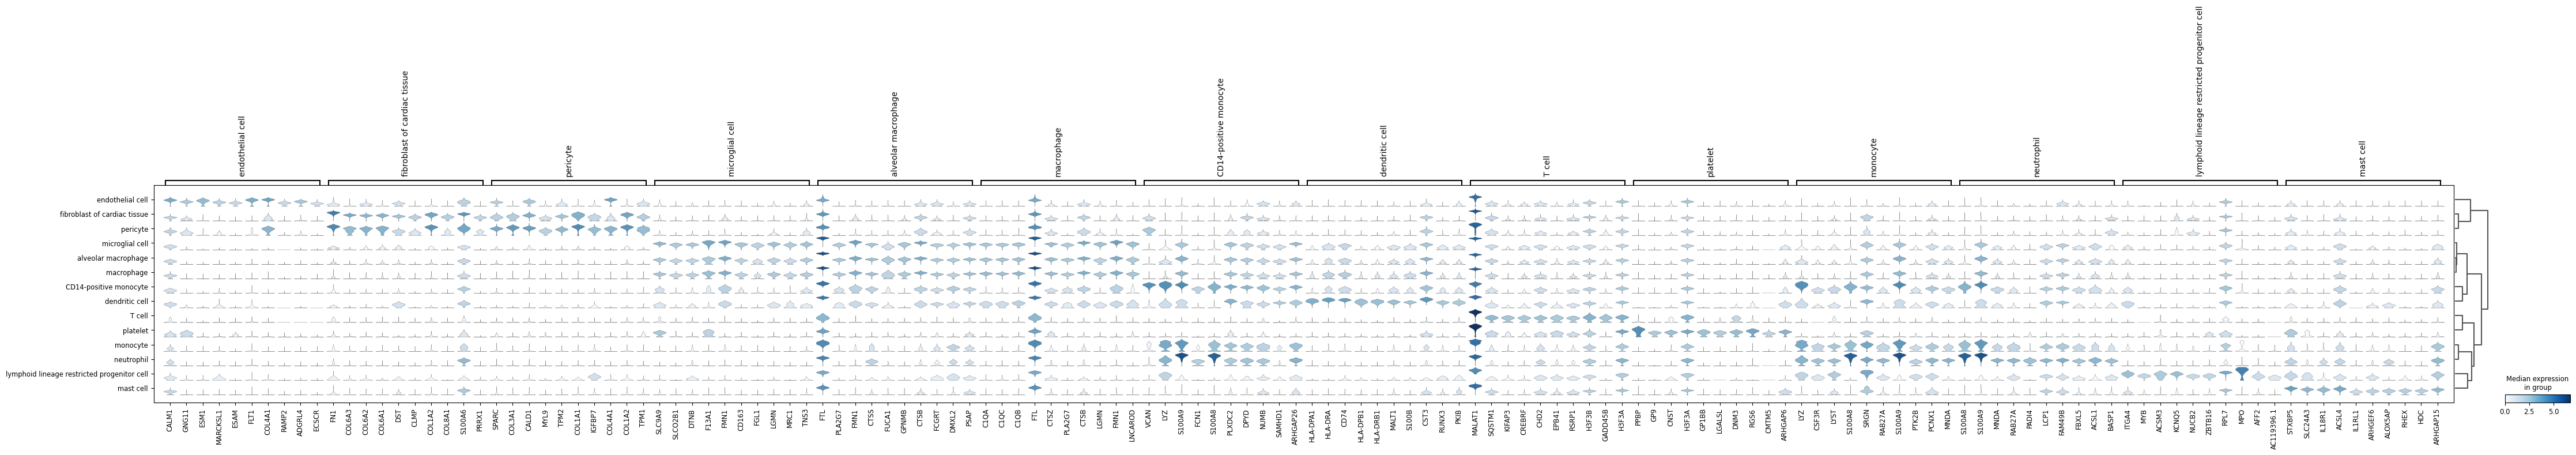

In [28]:
sc.pl.rank_genes_groups_stacked_violin(adata, key="DE_WILCOX")